In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import Input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import StandardScaler
from keras.constraints import Constraint
from keras.regularizers import Regularizer
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

print(tf.__version__)

Using TensorFlow backend.


1.14.0


In [2]:
data = pd.read_csv("trainDFS.csv")

X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values
Y = keras.utils.to_categorical(Y.reshape(Y.shape[0],1))

print(X.shape, Y.shape)

(1105, 1524) (1105, 2)


In [3]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

In [4]:
class DiagonalWeight(Constraint):
    """Ограничения на веса первого слоя
    """
    def __call__(self, w):
        N = keras.backend.int_shape(w)[-1]
        m = keras.backend.eye(N)
        w *= m
        return w
        
class ZeroBias(Constraint):
    """Ограничения на bias первого слоя
    """
    def __call__(self, w):
        N = keras.backend.int_shape(w)[-1]
        w = keras.backend.zeros(N)
        return w

    
class dfs_regularization_w(Regularizer):
    """Регуляризация первого слоя
    """
    def __init__(self,lambda1=0.0001,lambda2=0.0001):
        self.lambda1=lambda1
        self.lambda2=lambda2
    
    def __call__(self, weight_matrix):
        w = tf.linalg.tensor_diag_part(weight_matrix)
        print(self.lambda1)
        return self.lambda1*((1-self.lambda2)/2*tf.norm(w,2)**2 + self.lambda2*tf.norm(w,1))

class dfs_regularization_W(Regularizer):
    """Регуляризация скрытых слоев
    """
    def __init__(self,alpha1=0.0001,alpha2=0.0001):
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        print(alpha1,alpha2)
        
    def __call__(self,weight_matrix):
        w = weight_matrix
        return self.alpha1*((1-self.alpha2)/2*tf.norm(w,ord='fro',axis=(0,1))**2 + self.alpha2*tf.norm(w,1))

In [5]:
def dfs_network(lambda1=0.03, lambda2=1, alpha1=0.0001, alpha2=0):
    """Архитектура dfs из статьи
    """
    inp = Input(shape = (X.shape[1],))

    skew = 0.2
    x = Dense(X.shape[1], kernel_constraint=DiagonalWeight(), bias_constraint=ZeroBias(),
              kernel_regularizer = dfs_regularization_w(lambda1,lambda2))(inp)
    x = LeakyReLU(skew)(x)
    x = Dropout(0.3)(x)

    x = Dense(2048,
              kernel_regularizer = dfs_regularization_W(alpha1,alpha2))(x)
    x = LeakyReLU(skew)(x)
    x = Dropout(0.3)(x)
    
    #x = Dense(512, activation = 'relu')(x)
    #x = Dropout(0.3)(x)
    #x = LeakyReLU(skew)(x)

    out = Dense(2,activation = 'softmax')(x)

    model = Model(inp, out)

    model.summary()
    
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
#Попытка найти оптимальные гиперпараметры для dfs_network
if False:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    # [0, 0.03] by a step of 0.0002

    lambda1 = 0.03
    lambda2 = 1
    alpha1 = 0.0001
    alpha2 = 0.0001

    params = {'lambda1':np.array([0.01,0.05]),
              'lambda2':np.array([0.1,1]),
              'alpha1':np.array([0.0001,0.0005]),
              'alpha2':np.array([0,0.0005])}

    model = KerasClassifier(build_fn=dfs_network, epochs = 10)

    model = GridSearchCV(estimator=model,param_grid=params,cv=3)#dfs_network()


    grid_result = model.fit(X_train,y_train)
    #history = model.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test))
    #history = model.train_on_batch(X,Y)

    #model.evaluate(X_test,y_test)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    if False:
        import matplotlib.pyplot as plt


        #print(history)

        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.show()


        #plt.plot(history.history['acc'])

W0715 00:01:41.696405  9208 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 00:01:41.732480  9208 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 00:01:41.741674  9208 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 00:01:41.771743  9208 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0715 00:01:41.779743  9208 deprecation.py:506] Fr

0.03
0.0001 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1524)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1524)              2324100   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1524)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1524)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              3123200   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0      

1105/1105 [==============================] - 3s 3ms/step - loss: 0.3155 - acc: 0.9014
Epoch 69/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3266 - acc: 0.8923A: 0s - loss: 0.3257 - ac
Epoch 70/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3259 - acc: 0.8923
Epoch 71/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3334 - acc: 0.8878
Epoch 72/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3496 - acc: 0.8833
Epoch 73/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3331 - acc: 0.8842
Epoch 74/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3392 - acc: 0.8860
Epoch 75/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3122 - acc: 0.9023
Epoch 76/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3197 - acc: 0.8923
Epoch 77/100
1105/1105 [==============================] - 3s 3ms/step - loss: 0.3142 - acc: 0.900

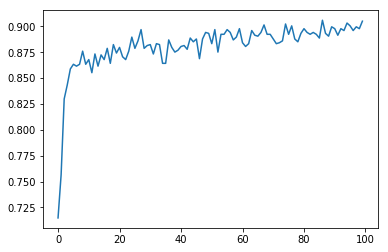

In [7]:
model = dfs_network()

history = model.fit(X,Y, epochs=100)

plt.plot(history.history['acc'])
plt.show()

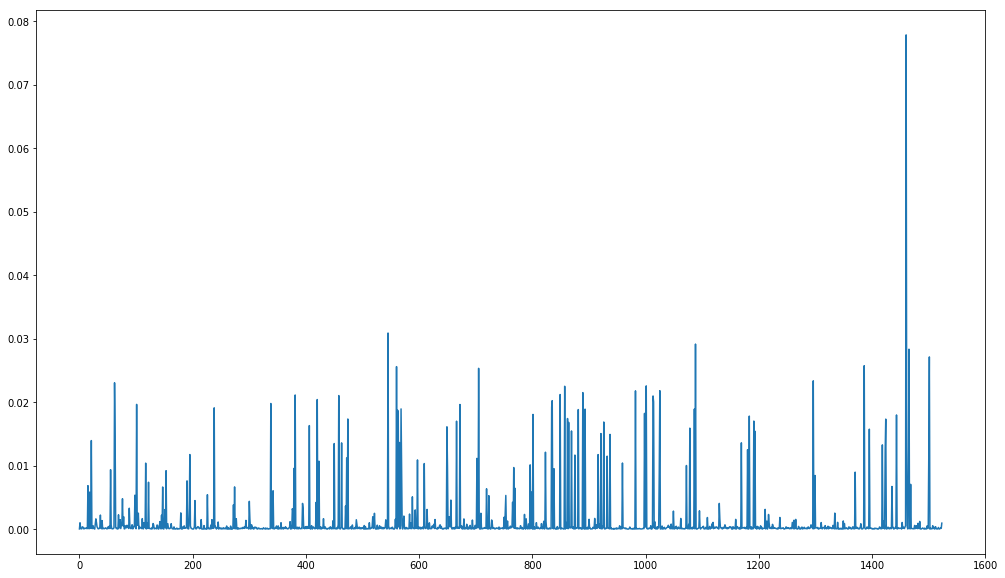

In [8]:
#Вывод получившихся весов с первого слоя dfs_network

plt.figure(figsize=(17,10))

plt.plot(np.diag(np.abs(model.layers[1].get_weights()[0])))

In [10]:
#Отбор весов по условию (сейчас веса, большие 0.01)
weights = pd.DataFrame(np.diag(np.abs(model.layers[1].get_weights()[0])),columns = ['importance'])
weights[weights['importance']>0.01].sort_values('importance', ascending=False)

,importance
1460,0.077859
545,0.030894
1088,0.029149
1465,0.028346
1501,0.027124
1386,0.025744
560,0.025597
705,0.025329
1296,0.023359
62,0.023050


0.8778280542986425


,importance
1460,0.024034
458,0.016521
868,0.012478
1077,0.010338
545,0.008251
101,0.007679
63,0.007066
108,0.006874
1212,0.006701
132,0.006146


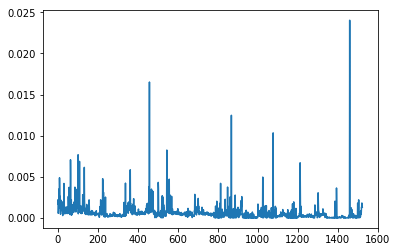

In [58]:
#Построение леса
X_forest = data.iloc[:, :-1].values
Y_forest = data.iloc[:, -1].values

X_train,X_test,y_train,y_test = train_test_split(X_forest,Y_forest,test_size=0.2,random_state=0)

sel = RandomForestClassifier(n_estimators = 1000)
sel.fit(X_train, y_train)
print(sel.score(X_test,y_test))

#Выбор признаков
feature_importances = pd.DataFrame(sel.feature_importances_,
                                   index = range(X_forest.shape[1]),
                                    columns=['importance']).sort_values('importance', ascending=False)

plt.plot(feature_importances.sort_index())

feature_importances[feature_importances['importance']>0.001]

In [77]:
#Вывод пересечения результатов двух алгоритмов по отбору признаков
tree_ind = feature_importances[feature_importances['importance']>0.001].index
dfs_ind = weights[weights['importance']>0.01].index

np.intersect1d(tree_ind,dfs_ind)

array([  21,   62,   63,  101,  117,  238,  338,  450,  458,  463,  472,
        545,  560,  562,  563,  565,  569,  702,  705,  849,  862,  889,
        916,  921, 1001, 1025, 1088, 1180, 1191, 1386, 1395, 1460, 1465,
       1500], dtype=int64)

In [87]:
#Сравнение лесов для данных с обработкой признаков с помощью DFS и без для разных уровней отбора весов
#Оптимальной границей получается 0.01, с ней отбирается где-то 80 признаков 

X_forest = data.iloc[:, :-1].values
Y_forest = data.iloc[:, -1].values

#X_train,X_test,y_train,y_test = train_test_split(X_forest,Y_forest,test_size=0.2,random_state=0)

sel = RandomForestClassifier(n_estimators = 200)
#sel.fit(X_train[:,dfs_ind], y_train)
#sel.score(X_test[:,dfs_ind],y_test)


    

dfs_list = [0.005,0.01,0.02,0.03]
 

for threshold in dfs_list:
    skf = StratifiedKFold(n_splits=4, random_state=42)
    dfs_ind = weights[weights['importance']>threshold].index
    full_score, dfs_score, forest_score = [],[],[]

    for _ in range(3):
        for train_index, test_index in skf.split(X_forest, Y_forest):
            X_train = X_forest[train_index]
            y_train = Y_forest[train_index]

            X_test = X_forest[test_index]
            y_test = Y_forest[test_index]

            sel.fit(X_train, y_train)
            full_score += [sel.score(X_test, y_test)]
            #print("Without DFS:",sel.score(X_test, y_test))

            sel.fit(X_train[:,dfs_ind], y_train)
            dfs_score += [sel.score(X_test[:,dfs_ind], y_test)]
            #print("DFS: ",sel.score(X_test[:,dfs_ind], y_test))

            sel.fit(X_train[:,tree_ind], y_train)
            forest_score += [sel.score(X_test[:,tree_ind], y_test)]


        print('-'*10)
    print("threshold: ",threshold)
    print("Forest mean: ",np.mean(forest_score))
    print("DFS mean: ",np.mean(dfs_score))
    print("All features mean: ",np.mean(full_score))

----------
----------
----------
threshold:  0.005
Forest mean:  0.8813951554471097
DFS mean:  0.8853378194121406
All features mean:  0.8765554223763298
----------
----------
----------
threshold:  0.01
Forest mean:  0.8823031325656502
DFS mean:  0.8880596024600106
All features mean:  0.8762502199835428
----------
----------
----------
threshold:  0.02
Forest mean:  0.8853257738267941
DFS mean:  0.8877565483749755
All features mean:  0.8747514582332507
----------
----------
----------
threshold:  0.03
Forest mean:  0.8835086978718278
DFS mean:  0.753285959580105
All features mean:  0.8750610523695596


In [89]:
#Попытка классифицировать плотной нейронной сетью c подобранными cvgrid параметрами.

def keras_network(n,hidden_n,skew = 0.2,dropout=0.5,reg=0.02, hidden_l = 2, lr = 0.005):

    inp = Input(shape = (n,))

    
    x = Dense(n, kernel_regularizer=keras.regularizers.l2(reg))(inp)
    x = LeakyReLU(skew)(x)
    x = Dropout(dropout)(x)
    
    for i in range(hidden_l):
        x = Dense(hidden_n, kernel_regularizer=keras.regularizers.l2(reg))(x)
        x = LeakyReLU(skew)(x)
        x = Dropout(dropout)(x)

    out = Dense(2,activation = 'softmax')(x)

    model = Model(inp, out)
    
    model.compile(optimizer = Adam(lr = lr), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

if True:
    dfs_ind = weights[weights['importance']>0.01].index
    print(len(dfs_ind))
    
    X_nn = X[:,dfs_ind]
    y_nn = Y
    
    skf = StratifiedKFold(n_splits=4)
        
    print(skf)  
    
    history = []
    for train_index, test_index in skf.split(X_nn, Y_forest):
        model = None # Clearing the NN.
        model = keras_network(len(dfs_ind),256,dropout=0.6,hidden_l=3,lr=0.005)
        history += [model.fit(X_nn[train_index], y_nn[train_index],
                             validation_data=(X_nn[test_index], y_nn[test_index]),epochs=30) ]                     

    #history2 = dense_model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs=30)
    
    history_last_epoch = []
    for h in history:
        history_last_epoch += [h.history['val_acc'][-1]]
    print(np.mean(history_last_epoch))

if False:    
    params = {'n':[len(dfs_ind)],
              'hidden_n':np.array([1024,1536]),
              'dropout':np.array([0.5]),
              'skew':np.array([0.2]),
              'hidden_l':np.array([4,5,6]),
              'lr':np.array([0.01])}

    model = KerasClassifier(build_fn=keras_network, epochs = 30)

    model = GridSearchCV(estimator=model,param_grid=params,cv=3)#dfs_network()


    grid_result = model.fit(X[:,dfs_ind],Y)
    #history = model.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test))
    #history = model.train_on_batch(X,Y)

    #model.evaluate(X_test,y_test)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

78
StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
Train on 828 samples, validate on 277 samples
Epoch 1/30
828/828 [==============================] - 5s 7ms/step - loss: 9.3260 - acc: 0.7403 - val_loss: 5.0045 - val_acc: 0.8773
Epoch 2/30
828/828 [==============================] - 0s 345us/step - loss: 3.3667 - acc: 0.8575 - val_loss: 1.9870 - val_acc: 0.8773
Epoch 3/30
828/828 [==============================] - 0s 339us/step - loss: 1.4051 - acc: 0.8937 - val_loss: 0.9648 - val_acc: 0.8917
Epoch 4/30
828/828 [==============================] - 0s 355us/step - loss: 0.7788 - acc: 0.9022 - val_loss: 0.6473 - val_acc: 0.8773
Epoch 5/30
828/828 [==============================] - 0s 355us/step - loss: 0.5977 - acc: 0.9022 - val_loss: 0.5539 - val_acc: 0.8773
Epoch 6/30
828/828 [==============================] - 0s 384us/step - loss: 0.5219 - acc: 0.9010 - val_loss: 0.4959 - val_acc: 0.8953
Epoch 7/30
828/828 [==============================] - 0s 351us/step - loss: 0.5058 - ac

Train on 829 samples, validate on 276 samples
Epoch 1/30
829/829 [==============================] - 5s 6ms/step - loss: 9.9657 - acc: 0.7286 - val_loss: 5.7725 - val_acc: 0.8913
Epoch 2/30
829/829 [==============================] - 0s 352us/step - loss: 3.9886 - acc: 0.8504 - val_loss: 2.3721 - val_acc: 0.9094
Epoch 3/30
829/829 [==============================] - 0s 340us/step - loss: 1.7033 - acc: 0.8794 - val_loss: 1.1034 - val_acc: 0.9058
Epoch 4/30
829/829 [==============================] - 0s 335us/step - loss: 0.9320 - acc: 0.8951 - val_loss: 0.7064 - val_acc: 0.8986
Epoch 5/30
829/829 [==============================] - 0s 345us/step - loss: 0.6701 - acc: 0.8890 - val_loss: 0.5440 - val_acc: 0.9094
Epoch 6/30
829/829 [==============================] - 0s 353us/step - loss: 0.5440 - acc: 0.8987 - val_loss: 0.5056 - val_acc: 0.8913
Epoch 7/30
829/829 [==============================] - 0s 347us/step - loss: 0.5294 - acc: 0.8878 - val_loss: 0.4573 - val_acc: 0.9022
Epoch 8/30
829/829

In [90]:
print("Mean validation score: ",np.mean(history_last_epoch))

Mean validation score:  0.8786908363171952


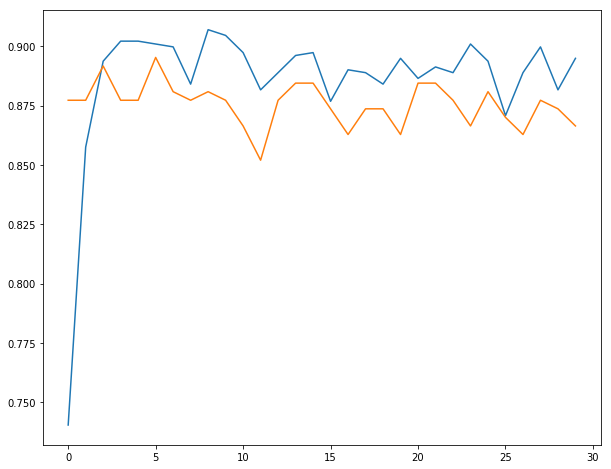

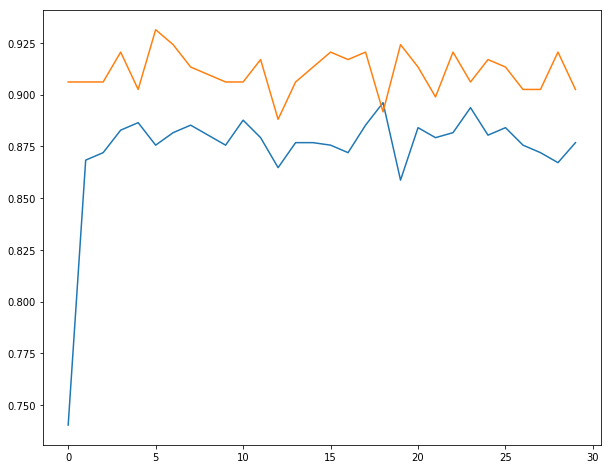

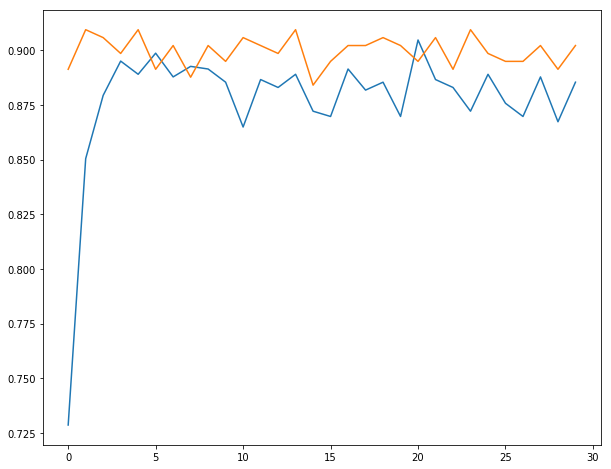

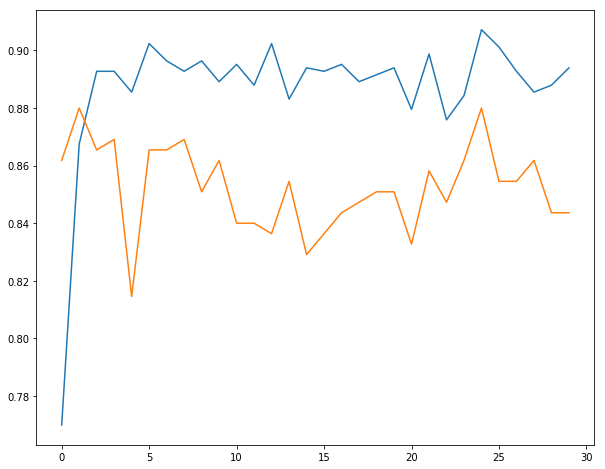

In [91]:
for i in range(4):
    plt.figure(figsize = (10,8))
    plt.plot(history[i].history['acc'])
    plt.plot(history[i].history['val_acc'])
    plt.show()